In [1]:
import openpyxl
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from tabulate import tabulate
import statistics
from math import pi, sin, cos, radians, asin, degrees
from mpl_toolkits.basemap import Basemap
import random

In [2]:
earthquake_value=7.0
name="LA_600.xlsx"

In [3]:
def change_in_latitude(km):

    earth_radius = 6371.0
    degrees_to_radians = math.pi/180.0
    radians_to_degrees = 180.0/math.pi
    
    return (km/earth_radius)*radians_to_degrees

    #.................................................................

def change_in_longitude(latitude, km):


    earth_radius = 6371.0
    degrees_to_radians = math.pi/180.0
    radians_to_degrees = 180.0/math.pi

    r = earth_radius*math.cos(latitude*degrees_to_radians)
    return (km/r)*radians_to_degrees

#........................................................................

from math import sin, cos, radians, degrees, atan2

def createCircleAroundWithRadius(lat, lon, radiusKm):

    EarthRadius = 6371  # Earth radius in kilometers

    latArray = []
    lonArray = []
    for brng in range(0, 366, 6):
        angle = radians(brng)
        lat2 = degrees(asin(sin(radians(lat)) * cos(angle) + 
                             cos(radians(lat)) * sin(angle) * cos(radians(radiusKm / EarthRadius))))
        lon2 = degrees(lon + degrees(atan2(sin(angle) * sin(radians(radiusKm / EarthRadius)) * cos(radians(lat)),
                                            cos(radians(lat)) * cos(radians(radiusKm / EarthRadius)) - sin(radians(lat)) * sin(radians(lat2)))))

        latArray.append(lat2)
        lonArray.append(lon2)

    return lonArray, latArray


In [4]:
def mean_val(number_array):

    N_Dim_mean = len(number_array)
    mean = sum(number_array)/float(N_Dim_mean)

    return mean



def std_var_val(number_array):


    N_Dim_var = len(number_array)
    mean_of_array = mean_val(number_array)

    adjusted_arguments = [((i-mean_of_array)**2)/float(N_Dim_var-1) for i in number_array]   # Sample variance

    variance = sum(adjusted_arguments)   

    standard_deviation = math.sqrt(variance) 

    return (standard_deviation, variance)

In [5]:
def compute_great_circle_distance(lat_1, lng_1, lat_2, lng_2):

    pic = 3.1415926535/180.0
    Radius = 6371.0

    lat_1 = float(lat_1) * pic
    lng_1 = float(lng_1) * pic
    lat_2 = float(lat_2) * pic
    lng_2 = float(lng_2) * pic
    
    delta_lng = lng_1 - lng_2
    
    delta_radians = math.sin(lat_1)*math.sin(lat_2) + math.cos(lat_1)*math.cos(lat_2)* math.cos(delta_lng)
    if delta_radians > 1.0:
        delta_radians = 1.0
    delta_radians = math.acos(delta_radians)
    
    great_circle_distance = delta_radians * Radius

    return great_circle_distance

In [6]:
def compute_burst_radius_gyration(index_list, mag, lat, lng, date, time, years):
    
    lat_list = []
    lng_list = []
    mag_list = []
    
    great_circle_distance_2 =   []
    
    for i in range(len(index_list)):

        lat_list.append(lat[index_list[i]])
        lng_list.append(lng[index_list[i]])
        mag_list.append(mag[index_list[i]])
        
        burst_centroid_lat = mean_val(lat_list)
        burst_centroid_lng = mean_val(lng_list)
        
    #   Compute Radius of Gyration
    
    for i in range(len(lat_list)):

        lat1 = burst_centroid_lat
        lng1 = burst_centroid_lng
        lat2 = lat_list[i]
        lng2 = lng_list[i]
        dist = compute_great_circle_distance(lat1, lng1, lat2, lng2)
            
        great_circle_distance_2.append(math.pow(dist,2))
        
    radius_gyration = math.pow(mean_val(great_circle_distance_2), 0.5)
    
    return radius_gyration, burst_centroid_lat, burst_centroid_lng

In [7]:
def reject_outliers_clusters(rgyr_cluster, year_cluster, sd_cluster):

    #   This is the spatial filtering based on radius of gyration 
    
    rgyr_cluster_filtered   =   []
    year_cluster_filtered   =   []
    
    median_rgyr = np.median(rgyr_cluster)
    
    print('')
    print('----------------------------------------')
    print('')
    print('Median Radius of Gyration: ', str(round(median_rgyr,2)) + ' (km)')
    print('')
 
    number_all_clusters = len(rgyr_cluster)

    for i in range(len(rgyr_cluster)):
    
        if rgyr_cluster[i] < sd_cluster * median_rgyr:
            rgyr_cluster_filtered.append(rgyr_cluster[i])
            year_cluster_filtered.append(year_cluster[i])
            
    number_reduced_clusters = len(rgyr_cluster_filtered)
    
    print('Fraction of Clusters Removed: ', str(100.0*(1 - float(number_reduced_clusters)/float(number_all_clusters))) + '%')
    print('')
    print('----------------------------------------')
    print('')

    return rgyr_cluster_filtered, year_cluster_filtered
    

In [8]:
def reject_outliers_earthquakes(index_list, data_lat, data_lng, sd_factor):

    #   This method removes lat-lng points that are far from the median of the calculated burst
    
    median_lat = np.median(data_lat)
    median_lng = np.median(data_lng)
    
    great_circle_distance   =   []
    data_lat_removed        =   []
    data_lng_removed        =   []
    index_list_removed      =   []
    
    for i in range(len(data_lat)):
        lat1 = median_lat
        lng1 = median_lng
        lat2 = data_lat[i]
        lng2 = data_lng[i]
        dist = compute_great_circle_distance(lat1, lng1, lat2, lng2)
        great_circle_distance.append(dist)
        
    median_gcdist = np.median(great_circle_distance)
    
    for i in range(len(data_lat)):
        if great_circle_distance[i] < sd_factor * median_gcdist:
            data_lat_removed.append(data_lat[i])
            data_lng_removed.append(data_lng[i])
            index_list_removed.append(index_list[i])
            
#     index_list_removed = index_list
            
    return index_list_removed

In [9]:
def clean_data_outliers(burst_index_test, lat, lng, burst_min_size, sd_factor):

    burst_index    =   []
        
    for i in range(len(burst_index_test)):
        index_list = burst_index_test[i]
        lat_list = []
        lng_list = []
            
        for j in range(len(index_list)):
            lat_list.append(lat[index_list[j]])
            lng_list.append(lng[index_list[j]])
    
        index_list_removed = reject_outliers_earthquakes(index_list, lat_list, lng_list, sd_factor)
        
        if len(index_list_removed) >= burst_min_size:
            burst_index.append(index_list_removed)
        
    #   Make sure all bursts are non-empty
            
    return burst_index

In [10]:
def combine_daily_count_bursts(min_daily_events, number_events, index_events):

    #   This method combines the daily counts into coherent burst event swarms
    
    temp_burst_index    =   []
    burst_index_prelim  =   []
    burst_index         =   []
    
    for i in range(len(number_events)):
         #   For the start of the burst
        if i == 0 and number_events[0] >= min_daily_events:    
            for j in range(len(index_events[0])):
                temp_burst_index.append(index_events[0][j])
            
        # for including foreshocks
        elif i > 0 and i< len(number_events)-1 and number_events[i] < min_daily_events and number_events[i+1] >= min_daily_events:
            for j in range(len(index_events[i])):
                temp_burst_index.append(index_events[i][j])
            
        #   Start a new burst if the old one is completed
        elif i > 0 and number_events[i] >= min_daily_events and number_events[i-1] < min_daily_events: #   Add this to burst
            for j in range(len(index_events[i])):
                temp_burst_index.append(index_events[i][j])
        
        #   Add this to the current burst
        elif i > 0 and number_events[i] >= min_daily_events and number_events[i-1] >= min_daily_events: #   Add this to burst
            for j in range(len(index_events[i])):
                temp_burst_index.append(index_events[i][j])

        #   Terminate the current burst and reset the temp_burst_index
        elif i > 0 and number_events[i] < min_daily_events and number_events[i-1] >= min_daily_events and len(temp_burst_index) > 0:
            burst_index_prelim.append(temp_burst_index)
            temp_burst_index    =   []
            
        else:
            pass
    
    # Ensure that the number of events in the burst is at least the required minimum
    
    for i in range(len(burst_index_prelim)):
        if len(burst_index_prelim[i]) >= min_daily_events:
            burst_index.append(burst_index_prelim[i])
            
    return  burst_index

In [11]:
def build_daily_counts(burst_min_size, min_daily_events, mag, lat, lng, date, time, yrs, sd_factor):

    # Initialize arrays to store daily event counts and indices
    max_date = max(date)
    min_date = min(date)
    max_duration = (max_date - min_date).days + 1  # Maximum duration in days
    number_events = [0 for _ in range(max_duration)]
    index_events = [[] for _ in range(max_duration)]

    # Loop through each earthquake event
    for i in range(len(date)):
        # Calculate the index corresponding to the event date
        day_of_event = (date[i] - min_date).days
        number_events[day_of_event] += 1  # Increment event count for the day
        index_events[day_of_event].append(i) 


    #############################    
    print("number_events:", number_events)   
    print("index events", index_events) 
    burst_index = combine_daily_count_bursts(min_daily_events, number_events, index_events)
    print("before cleaning")
    print(len(burst_index))
    
    #   Clean the data by removing outliers
    
    burst_index =   clean_data_outliers(burst_index, lat, lng, burst_min_size, sd_factor)
    print("after cleaning")
    print(len(burst_index))
    #   ---------------------------------------------------
    
    basic_event_rate = float(len(yrs))/(float(max(yrs)-min(yrs))*365.0)
    
    burst_number = 0
    
    total_number_events_in_bursts = 0
    number_events_in_large_bursts = 0
    
    return number_events, index_events, burst_index

In [12]:
def plot_swarm_event_counts(completeness_mag, location, sd_factor):
    # Read data from Excel file
    df = pd.read_excel(name, parse_dates=['Date '])
    #Rename 'Date ' to 'Date'
    df.rename(columns={'Date ': 'Date'}, inplace=True)

    # Extract relevant columns
    yrs = df['Date'].dt.year
    lng = df['longitude']
    lat = df['latitude']
    mag = df['mag']
    dep = df['depth']
    time = df['Time'].astype(str)
    date = df['Date']

    # Convert dates to years 
    yrs = [int(str(d).split('-')[0]) for d in date]

    # Build daily counts and identify bursts
    min_daily_events, burst_min_size = 1, 1
    number_events, index_events, burst_index = build_daily_counts(
        burst_min_size, min_daily_events, mag, lat, lng, date, time, yrs, sd_factor)

    # Display information
    print('----------------------------------------')
    print('')
    print('Total Number of Bursts for the', location, 'Catalog: ', len(burst_index))
    print('')

    # Format location name
    city = location.replace('_', ' ').title()

    return burst_index, number_events, min_daily_events, burst_min_size, mag, lat, lng, date, time, yrs


In [13]:
def plot_radgyr_time(burst_min_size, completeness_mag, Location, \
         burst_index, mag, lat, lng, date, time, years):
        
    #   This routine plots the space-time migration of the swarms, symbol size denotes radius of gyration
    print("In function printing 2")
    print(date)
    
    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    #settings_params = get_settings()

    region_type = "Circle"
    earthquake_depth    =   350
    Circle_Location     =   "LA"
    Circle_Lat          =   36.778259
    Circle_Lng          =   -119.417931
    Circle_Radius        =   600
    
    mean_lat        =   []
    mean_lng        =   []
    mean_yrs        =   []
    swarm_distance  =   []
    year_list       =   []
    radgyr_list     =   []
    year_swarm   =   []
    
    for i in range(len(burst_index)):        #   Iterating over the bursts/swarms
    
        if len(burst_index[i]) >= burst_min_size:
        
            index_list = burst_index[i]
            lat_list = []
            lng_list = []
            yrs_list = []
                
            for j in range(len(burst_index[i])):
            
                lat_list.append(lat[index_list[j]])
                lng_list.append(lng[index_list[j]])
                yrs_list.append(years[index_list[j]])
                
            year_swarm.append(years[index_list[0]])
            radius_gyration, burst_centroid_lat, burst_centroid_lng = \
                    compute_burst_radius_gyration(burst_index[i], mag, lat, lng, date, time, years)
            
            radgyr_list.append(radius_gyration)     #   This is the time series we want to use EMA on
            
    radgyr_index = list(range(len(radgyr_list)))

    mark_size = 3

    plt.plot(year_swarm,radgyr_list,'--', lw=0.8)
    plt.plot(year_swarm,radgyr_list,'bo', ms = mark_size)
            
    plt.grid(True, ls = '--', lw = 0.5)
        
    SupTitle_text = 'Radius of Gyration for Swarms vs. Time'

    plt.suptitle(SupTitle_text, fontsize=12)
    
    Title_text = 'Radius (Km) vs. Time for Minimum Swarm Size of ' + str(burst_min_size) + ' Events near ' + City_Location
    plt.title(Title_text, fontsize=8)
    
    plt.ylabel('Radius of Gyration (Km)', fontsize = 8)
    plt.xlabel('Time (Year)', fontsize = 8)

    plt.close('all')

    return
    

In [14]:
def EMA_weights(N_events, N_Steps):

    #   This method computes the weights for the Exponential Weighted Average (EMA) for N and alpha

    alpha = 2./float((N_Steps+1))

    #   time_series_list is the time series of floating point values
    #       arranged in order of first element in list being earliest

    assert 0 < alpha <= 1
    
    weights = []
    
    #   Define the weights
    
    for i in range(0,N_events):
        weight_i = (1.0-alpha)**i
        weights.append(weight_i)
        
    sum_weights = sum(weights)
    weights =  [i/sum_weights for i in weights]
     
    return weights
    

In [15]:
def EMA_weighted_time_series(time_series, N_Steps):

    #   This method computes the Exponential Weighted Average of a list.  Last
    #       in the list elements are exponentially weighted the most

    N_events = len(time_series)
    
    weights = EMA_weights(N_events, N_Steps)
    
    
    #[i**1.5 for i in weights]
    weights_reversed = list(reversed(weights))#1
    #weights_reversed = list(weights)

    EMA_weighted_ts = []
    partial_weight_sum = 0.
    
    for i in range(N_events):
        partial_weight_sum += weights[i]
        weighted_ts = round(float(time_series[i])*weights_reversed[i],4)#4 round-off till 4th value
        
        EMA_weighted_ts.append(weighted_ts)
        
    partial_weight_sum = round(partial_weight_sum,4)#4
    sum_value = sum(EMA_weighted_ts)
    
    if (float(partial_weight_sum)) <= 0.0:
        sum_value = 0.0001#0.0001
        partial_weight_sum = 1.
    
    weighted_sum = float(sum_value)/float(partial_weight_sum)
    
    return weighted_sum

In [16]:
def reject_outliers_clusters_in_EMA(ratio_limit, burst_index, burst_min_size, mag, lat, lng, date, time, years):

    #   This method removes clusters that are not compact
    
    mass_list           =   []
    year_list           =   []
    radgyr_list         =   []
    index_cluster       =   []
    centroid_lat_list   =   []
    centroid_lng_list   =   []
    
#     for i in range(3,len(burst_index)):        #   Iterating over the bursts/swarms
    for i in range(len(burst_index)):        #   Iterating over the bursts/swarms
    
        if len(burst_index[i]) >= burst_min_size:
        
            index_list = burst_index[i]
            lat_list    = []
            lng_list    = []

            
            mass_list.append(float(len(burst_index[i])))    #   Number of events in the burst

            year_list.append(years[burst_index[i][0]])      #   Year of the first event in the burst
            
            for j in range(len(burst_index[i])):
            
                lat_list.append(lat[index_list[j]])
                lng_list.append(lng[index_list[j]])

            radius_gyration, burst_centroid_lat, burst_centroid_lng = \
                    compute_burst_radius_gyration(burst_index[i], mag, lat, lng, date, time, years)
            
            radgyr_list.append(radius_gyration)     #   This is the time series we want to use EMA on
            
            index_cluster.append(index_list[0])
            
            centroid_lat_list.append(burst_centroid_lat)
            centroid_lng_list.append(burst_centroid_lng)
            
    density_list   =   []
    
    for i in range(len(mass_list)):
        density = mass_list[i]/((radgyr_list[i]))
        density_list.append(density)
        
    density_list = [math.log(density_list[i],10) for i in range(len(density_list))]
    
    rgyr_cluster_filtered   =   []
    year_cluster_filtered   =   []
    index_cluster_filtered  =   []
    centroid_lat_filtered   =   []
    centroid_lng_filtered   =   []
    
    for i in range(len(mass_list)):
        if density_list[i] >= ratio_limit:
            rgyr_cluster_filtered.append(radgyr_list[i])
            year_cluster_filtered.append(year_list[i])
            index_cluster_filtered.append(index_cluster[i])
            centroid_lat_filtered.append(centroid_lat_list[i])
            centroid_lng_filtered.append(centroid_lng_list[i])
        
    return rgyr_cluster_filtered, year_cluster_filtered, index_cluster_filtered, centroid_lat_filtered, centroid_lng_filtered

In [17]:
def plot_radgyr_EMA_time(burst_min_size, completeness_mag, Location, N_Steps,\
        circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
        ratio_limit, sd_factor, cutoff_start_year):
 
    region_type = "Circle"
    earthquake_depth    =   350
    Circle_Location     =   "LA"
    Circle_Lat          =   36.778259
    Circle_Lng          =   -119.417931
    Circle_Radius        =   600
    
    mean_lat        =   []
    mean_lng        =   []
    mean_yrs        =   []
    swarm_distance  =   []
    year_list       =   []
    radgyr_list     =   []
    radgyr_EMA_list =   []
    year_swarm      =   []
    
    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    for i in range(3,len(burst_index)):   #3     #   Iterating over the bursts/swarms
    
        if len(burst_index[i]) >= burst_min_size:
        
            index_list = burst_index[i]
            lat_list = []
            lng_list = []
            yrs_list = []
                
            for j in range(len(burst_index[i])):
            
                lat_list.append(lat[index_list[j]])
                lng_list.append(lng[index_list[j]])
                yrs_list.append(years[index_list[j]])
                
            radius_gyration, burst_centroid_lat, burst_centroid_lng =\
                     compute_burst_radius_gyration(burst_index[i], mag, lat, lng, date, time, years)
            
            radgyr_list.append(radius_gyration)     #   This is the time series we want to use EMA on
            year_swarm.append(years[index_list[0]])

#   Filter the clusters now, we filtered the events in the clusters previously
    
    radgyr_list, year_swarm, index_swarm, centroid_lat, centroid_lng = \
            reject_outliers_clusters_in_EMA(ratio_limit, burst_index, burst_min_size, mag, lat, lng, date, time, years)
    
    average_rate_start_date =   circle_catalog_date_start
    average_rate_end_date   =   circle_catalog_date_end
    
    if average_rate_end_date < 1990.0:#1990
        average_rate_end_date = 1990.0      #   The beginning of decent digital data     #1990
    
    year_interval = average_rate_end_date - average_rate_start_date
    
    number_earthquakes = 0
    number_bursts_in_plot = 0
    
    for i in range(len(burst_index)):
        if years[burst_index[i][0]] >= average_rate_start_date:
            number_earthquakes += 1
            number_bursts_in_plot += 1
        
    for i in range(1,len(radgyr_list)+1):
        RG_list_raw = []
        
        for j in range(i):
            RG_list_raw.append(radgyr_list[j])
            
#         RG_list_raw = [math.log(i,10) for i in RG_list_raw]
        
        radgyr_EMA = EMA_weighted_time_series(RG_list_raw, N_Steps)
        
        radgyr_EMA_list.append(radgyr_EMA)
        
#     radgyr_EMA_list = [10**i for i in radgyr_EMA_list]    #   Convert from Log back to km
        
    #   Determine which bursts occurred after 1990.0
    
#     kk = 0
    
    year_swarm_reduced  =   []
    radgyr_EMA_reduced  =   []
    
    for i in range(len(year_swarm)):
        if year_swarm[i] > cutoff_start_year:
            year_swarm_reduced.append(year_swarm[i])
            radgyr_EMA_reduced.append(radgyr_EMA_list[i])
            
    year_swarm = year_swarm_reduced
    radgyr_EMA_list = radgyr_EMA_reduced
    
    earthquake_year     =   []
    earthquake_mags     =   []
    earthquake_date     =   []
    earthquake_time     =   []
    earthquake_lat      =   []
    earthquake_lng      =   []
    
    for i in range(len(years)):
        if float(mag[i]) >= earthquake_value:#6.0
            earthquake_year.append(years[i])
            earthquake_mags.append(mag[i])
            earthquake_date.append(date[i])
            earthquake_time.append(time[i])
            earthquake_lat.append(lat[i])
            earthquake_lng.append(lng[i])
            
    mark_size = 2#2
    
    EQ_Table = []

    for i in range(0,len(earthquake_date)):
        EQ_Table.append([i+1, earthquake_date[i], \
                earthquake_year[i],earthquake_time[i], earthquake_mags[i], earthquake_lat[i], earthquake_lng[i]])
    
    
    print('')
    print('----------------------------------------------------------')
    print('')
    print('ENF, CLF, len(year_swarm), len(radgyr_EMA_list): ', ratio_limit, sd_factor, len(year_swarm), len(radgyr_EMA_list))
    

# 
# ---------------------------------------

                
    plt.plot(year_swarm,radgyr_EMA_list, linestyle='--', lw=0.5, color='b', zorder=3)
    plt.plot(year_swarm,radgyr_EMA_list,'b.', ms = 4, zorder=3)
    
    plt.gca().invert_yaxis()
            
    plt.grid(True, lw = 0.5, linestyle='dotted', zorder=0, axis = 'y')
    
    xmin,xmax = plt.xlim()
#     xmin,xmax = plt.xlim(1990,xmax)
    ymin, ymax = plt.ylim()
    
    min_plot_line = [ymin for i in range(len(year_swarm))]
    plt.fill_between(year_swarm,min_plot_line, radgyr_EMA_list, color='c', alpha=0.1, zorder=0)
    
    for i in range(len(earthquake_year)):
        x_eq = [earthquake_year[i], earthquake_year[i]]
        y_eq = [ymin,ymax]
        
#         if float(earthquake_mags[i]) < 6.5 and float(earthquake_mags[i]) >= 6.0 and float(earthquake_year[i]) >= 1980 :
#             plt.plot(x_eq, y_eq, '--', color='c', lw=0.8, zorder=0)
#                         
        if float(earthquake_mags[i]) >= 6.0 and float(earthquake_mags[i]) < 7.0  and float(earthquake_year[i]) >= cutoff_start_year:#6.0,   7.0
            plt.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=1)
            
        if float(earthquake_mags[i]) >= 7.0 and float(earthquake_year[i]) >= cutoff_start_year:#7.0
            plt.plot(x_eq, y_eq, 'r', linestyle='--', lw=0.7, zorder=2)
            
    xmin,xmax = plt.xlim()
    ymin, ymax = plt.ylim()
#     plt.ylim(30,ymax)
#     
    plt.minorticks_on()
    
    SupTitle_text = 'Radius of Gyration for Swarms M $\geq$' + str(completeness_mag) + ' vs. Time Within ' + str(Circle_Radius) + ' Km of ' +  City_Location

    plt.suptitle(SupTitle_text, fontsize=10, y = 0.96)

    
    plt.ylabel('Radius of Gyration (Km), Inverted Scale', fontsize = 12)
    plt.xlabel('Time (Year)', fontsize = 12)

    plt.show()
    plt.close('all')

    return N_Steps, radgyr_list, year_swarm, index_swarm, centroid_lat, centroid_lng 

In [18]:
def plot_cluster_density_rgyr(burst_min_size, completeness_mag, Location, N_Steps,\
        circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
        ratio_limit, cutoff_start_year):
        
    #   This plots the density against the radius of gyration, to allow identification of families of burst clusters
    
    region_type = "Circle"
    earthquake_depth    =   350
    Circle_Location     =   "LA"
    Circle_Lat          =   36.778259
    Circle_Lng          =   -119.417931
    Circle_Radius        =   600
    
    
    mean_lat        =   []
    mean_lng        =   []
    mean_yrs        =   []
    swarm_distance  =   []
    radgyr_list     =   []
    radgyr_EMA_list =   []
    mass_list       =   []
    
    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    mass_list   = []
    
    for i in range(3,len(burst_index)):        #   Iterating over the bursts/swarms
    
        if len(burst_index[i]) >= burst_min_size:
        
            index_list = burst_index[i]
            lat_list    = []
            lng_list    = []
            mass_list.append(float(len(index_list)))

                
            for j in range(len(burst_index[i]) and years[index_list[0]] >= cutoff_start_year):
            
                lat_list.append(lat[index_list[j]])
                lng_list.append(lng[index_list[j]])

                
            radius_gyration, burst_centroid_lat, burst_centroid_lng = \
                    compute_burst_radius_gyration(burst_index[i], mag, lat, lng, date, time, years)
            
            radgyr_list.append(radius_gyration)     #   This is the time series we want to use EMA on
            
    density_list   =   []
    for i in range(len(mass_list)):
        density = mass_list[i]/((radgyr_list[i]))
        density_list.append(density)
        
    mean_density_list = mean_val(density_list)
    
    median_density_list = statistics.median(density_list)
    
    Log_10_median_density_list = math.log(median_density_list,10)
    
    Log_10_mean_density_list = math.log(mean_density_list,10)
        
    density_list = [math.log(density_list[i],10) for i in range(len(density_list))]
    
    mean_log_10_density = mean_val(density_list)
    mean_log_10_density = round(mean_log_10_density,2)
    
    std_dev_log_10_density, variance_dev_log_10_density = std_var_val(density_list)
    std_dev_log_10_density = round(std_dev_log_10_density,2)
    
    print('')
    print('----------------------------------------------------------')
    print('')
    print('Mean(Density): ', mean_density_list)
    print('')
    print('Log_10_mean_density_list: ', Log_10_mean_density_list)
    print('')
#    print 'Mean Log_10(Density):', round(sum(density_list)/float(len(density_list)),2)
    print('Mean Log_10(Density):', mean_log_10_density, '+/-', std_dev_log_10_density)
    print('')
    print('Median Log_10(Density):', statistics.median(density_list))
    print('')
    print('Log_10_median_density_list: ', Log_10_median_density_list)
    print('')
    print('----------------------------------------------------------')
    print('')
        
#     print 'len(density_list), len(radgyr_list): ', len(density_list), len(radgyr_list)

    plt.plot(radgyr_list, density_list,'b.', ms = 4, zorder=1)
            
    plt.grid(True, lw = 0.5, linestyle='dotted', zorder=0, axis = 'both')
    
    
    xmin,xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    x_ratio = [xmin,xmax]
    y_ratio = [ratio_limit,ratio_limit]
    plt.plot(x_ratio,y_ratio, '--',color='red', lw=1.0)
#     
    plt.minorticks_on()
    
    SupTitle_text = 'Burst Cluster Density vs. Radius of Gyration for M $\geq$' + str(completeness_mag) + ' near ' +  City_Location

    plt.suptitle(SupTitle_text, fontsize=10)
    
    Title_text = 'Swarms Size > ' + str(burst_min_size) + ' Events Within ' + str(Circle_Radius) + ' Km, at Depth < '\
            +str(earthquake_depth) + ' Km'
            
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)

    plt.title(Title_text, fontsize=8)
    
    plt.ylabel('$Log_{10}$ (Mass Ratio, N/Km)', fontsize = 8)
    plt.xlabel('Radius of Gyration (Km)', fontsize = 8)

    plt.show()
    plt.close('all')

    return

In [19]:
def map_swarm_centroids(Location, burst_index, mag, lat, lng, date, time, years, cutoff_start_year, cutoff_start_date):
                
    #settings_params = get_settings()

    region_type = "Circle"
    earthquake_depth    =   350
    Circle_Location     =   "LA"
    Circle_Lat          =   36.778259
    Circle_Lng          =   -119.417931
    Circle_Radius        =   600

    radgyr_list     =   []
    centroid_lat    =   []
    centroid_lng    =   []
    year_swarm      =   []
    
    for i in range(len(burst_index)):
        index_list = burst_index[i]
        radius_gyration, burst_centroid_lat, burst_centroid_lng = \
            compute_burst_radius_gyration(index_list, mag, lat, lng, date, time, years)
            
        radgyr_list.append(radius_gyration)
        centroid_lat.append(burst_centroid_lat)
        centroid_lng.append(burst_centroid_lng)
        year_swarm.append(years[index_list[0]])
        
    earthquake_dates    =   []
    

    earthquake_lat  =   []
    earthquake_lng  =   []
    earthquake_mag  =   []
    earthquake_year =   []
    
    for i in range(len(years)):
        if float(mag[i]) >= earthquake_value:#6.0
            earthquake_lat.append(lat[i])
            earthquake_lng.append(lng[i])
            earthquake_mag.append(mag[i])
            earthquake_year.append(years[i])
            
            if float(mag[i]) >= earthquake_value:#7.0
                earthquake_dates.append(years[i])

    centroid_lat_list   =   []
    centroid_lng_list   =   []
    centroid_yrs_list   =   []
    
    color_index         =   ['c' for i in range(len(burst_index))]
    
    
    for i in range(len(burst_index)):
    
        lat_list = []
        lng_list = []
        mag_list = []
        
        for j in range(len(burst_index[i])):

            lat_list.append(lat[burst_index[i][j]] )
            lng_list.append(lng[burst_index[i][j]] )
            mag_list.append(mag[burst_index[i][j]] )
        
    #.................................................................
    
        cent_lat = mean_val(lat_list)
        cent_lng = mean_val(lng_list)
        cent_year= years[burst_index[i][0]]
        
        centroid_lat_list.append(cent_lat)
        centroid_lng_list.append(cent_lng)
        centroid_yrs_list.append(cent_year)
        ##############################
        
        
        print("I am printing earthquake dates")
        print(earthquake_dates)
        if centroid_yrs_list[i] < earthquake_dates[0] and centroid_yrs_list[i] >= float(cutoff_start_year):
            color_index[i] = 'c'
            
        elif centroid_yrs_list[i] >= earthquake_dates[0] and centroid_yrs_list[i] < earthquake_dates[1]:
            color_index[i] = 'g'
            
        elif centroid_yrs_list[i] >= earthquake_dates[1] and centroid_yrs_list[i] < earthquake_dates[2]:
            color_index[i] = 'b'

        elif centroid_yrs_list[i] >= earthquake_dates[2]:
            color_index[i] = 'r'
    
    lat_0_center = Circle_Lat
    lon_0_center = Circle_Lng
    
    delta_lat = change_in_latitude(Circle_Radius)
    delta_lat = abs(delta_lat)
    delta_lng = change_in_longitude(Circle_Lat, Circle_Radius)
    delta_lng = abs(delta_lng)
    
    llcrnrlat  = SWLat_local = Circle_Lat - delta_lat - 0.5
    llcrnrlon  = SWLng_local = Circle_Lng - delta_lng - 0.5
    urcrnrlat  = NELat_local = Circle_Lat + delta_lat + 0.5
    urcrnrlon  = NELng_local = Circle_Lng + delta_lng + 0.5

    m = Basemap(projection='cyl',llcrnrlat=SWLat_local, urcrnrlat=NELat_local,
            llcrnrlon=SWLng_local, urcrnrlon=NELng_local, lat_0=lat_0_center, lon_0=lat_0_center, lat_ts=20, resolution='h')

    m.drawmeridians(np.arange(0,360,2.0),labels=[0,0,0,1], color='k', textcolor='k', linewidth=0.4, fontsize=8)
    m.drawparallels(np.arange(-90,90,2.0),labels=[1,0,0,0],color='k', textcolor='k', linewidth=0.4, fontsize=8)

    m.fillcontinents(color='tan', lake_color='aqua')
    try:
        m.drawcoastlines(linewidth=0.4, linestyle='solid', color='k')
    except:
        pass
    m.drawcountries()
    m.drawstates()
    m.drawrivers()
    
    mark_size = 1.5
    
    #   ------------------------------------------------------
    
    for i in range(len(color_index)):
    
        if centroid_yrs_list[i] >= cutoff_start_year:
    
            cent_lat = [centroid_lat_list[i]]
            cent_lng = [centroid_lng_list[i]]
        
            m.plot(cent_lng, cent_lat, "o", color=color_index[i], ms=mark_size)

    x_circle_dg, y_circle_dg = createCircleAroundWithRadius(Circle_Lat, Circle_Lng, Circle_Radius)
    m.plot(x_circle_dg, y_circle_dg, "b--", lw=0.9)
    
    #   ------------------------------------------------------

    for i in range(len(earthquake_lat)):
        if float(earthquake_mag[i])  >= 6.3 and float(earthquake_mag[i]) < 7.3 and earthquake_year[i] >= float(cutoff_start_year):#6.0,     7.0
                m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=5, mfc='y', mec='k', mew=0.5)
        elif float(earthquake_mag[i]) >= 7.3 and earthquake_year[i] >= float(cutoff_start_year):#7.0
                m.plot(earthquake_lng[i], earthquake_lat[i], "*", ms=8, mfc='y', mec='k', mew=0.5)
            
    #   ------------------------------------------------------

    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]
    
    first_index         = burst_index[0][0]
    second_index        = len(burst_index) - 1
    last_event_index    = len(burst_index[second_index]) -1
    second_index    = burst_index[second_index][last_event_index]
    
    start_date = date[first_index]
    end_date   = date[second_index]
    
    number_bursts_since_start = 0
    for i in range(len(burst_index)):
        if centroid_yrs_list[i] >= cutoff_start_year:
            number_bursts_since_start += 1
    
    if Circle_Location != 'None':
        Circle_Location_actual = Circle_Location.split('-')
        SupTitle_text = 'Centroids for ' + str(number_bursts_since_start) + ' Burst Events near ' + City_Location 

    plt.suptitle(SupTitle_text, y=0.97, fontsize=12)
    # 
    m.drawmapboundary(fill_color='#e6e6ff')

    plt.show()
    plt.close('all')

    return None

In [20]:
def weight_optimizer():

    interpolation_file_name = 'interpolation_file.txt'
    interpolation_file = open(interpolation_file_name, 'r')
    
    count = len(open(interpolation_file_name).readlines(  ))
    print('')
    print('length of interpolation file: ',count)
    print('')
    
    ENF_list    =   []
    CLF_list    =   []

    radii_list  =   [[] for i in range(count)]  #   A list of lists
    
    i=0
    for line in interpolation_file:

        items = line.strip().split()
#         print(items)
#         print(items[6],items[7],items[8],items[9])
        
        ENF_list.append(items[0])
        CLF_list.append(items[1])
        
        radii_list[i].extend((items[6],items[7],items[8],items[9]))
        
        i += 1
        

    initial_weights =   [1.0/float(count) for i in range(count)]     #   We start with equal weighting
    
    adjusted_weights=   [1.0/float(count) for i in range(count)]

    
    mean_radius_4 = [0. for i in range(4)]
    
    for i in range(4):
        for j in range(count):
#             mean_radius[i] += random_weights[j]*float(radii_list[j][i])
            mean_radius_4[i] += initial_weights[j]*float(radii_list[j][i])
    
    mean_radius_init = np.mean(mean_radius_4)
    mean_radius_init = round(mean_radius_init,2)
    
    std_radius_init  = np.std(mean_radius_4)
    std_radius_init = round(std_radius_init,2)
    
    mean_radius_4_init = [round(mean_radius_4[i],2) for i in range(4)]
    
    trials = 20000 #20000
    
    min_mean_radius = mean_radius_init
    min_std_radius  = std_radius_init
    
    for k in range(trials):       
    
        random_weights = random.sample(range(0, count), count)
        sum_of_weights = sum(random_weights)
        random_weights = [float(random_weights[i])/sum_of_weights for i in range(len(random_weights))]
        
        mean_radius_4 = [0. for i in range(4)]
        
        for i in range(4):

            for j in range(count):
                mean_radius_4[i] += random_weights[j]*float(radii_list[j][i])
    
        mean_radius = np.mean(mean_radius_4)
        mean_radius = round(mean_radius,2)
    
        std_radius  = np.std(mean_radius_4)
        std_radius = round(std_radius,2)
        
        mean_radius_4 = [round(mean_radius_4[i],2) for i in range(4)]

        
        if (std_radius < min_std_radius):
            min_std_radius = std_radius
            min_mean_radius = mean_radius
            min_random_weights = random_weights
            
#     print(min_random_weights)


        
    print('')
    print('------------------------------------------------')
    print('')
    print('Non-adjusted Mean_Radii (Km): ', mean_radius_4_init)
    print('')
    print('Mean Non-Adjusted Radius Value: ', mean_radius_init, '+/-', std_radius_init, 'Km')
    print('')
    print('Minimum Mean Adjusted Radius Value: ', min_mean_radius, '+/-', min_std_radius, 'Km')
    print('')
    
    for i in range(4):
        values_list = []
        
        for j in range(count):
            values_list.append(float(radii_list[j][i]))
        
        mean_ts, std_ts = time_series_mean_std(values_list, min_random_weights)
        
        print('EQ: ',i+1,' Minimum Mean Adjusted Radius Value: ', round(mean_ts,2), '+/-', round(std_ts,2), 'Km')
        print('')
    
    print('------------------------------------------------')
    print('')

    
    interpolation_file.close()

#     return initial_weights and adjusted weights

    return initial_weights, adjusted_weights
    
    #.................................................................
    
def time_series_mean_std(values_list, weight_list):

#   This method computes the mean and standard deviation of the time series
#       at every time step using the adjusted time series weights

    mean_ts = 0.
    std_ts = 0.
    
    mean_ts_list = []
    
    for i in range(len(values_list)):
    
        mean_term = float(values_list[i])*float(weight_list[i])
        mean_ts_list.append( mean_term )
        
    mean_ts = sum(mean_ts_list)
    
    variance_ts_list = []
    
    for i in range(len(values_list)):
    
        variance_term = float(weight_list[i]) * math.pow(float(values_list[i])-float(mean_ts),2)
        variance_ts_list.append( variance_term )
            
    std_ts = math.pow(sum(variance_ts_list),0.5)

    return mean_ts, std_ts
    
    #.................................................................

In [21]:
def write_precursor_radii_to_file(years, mag, year_swarm_regular,radgyr_list_regular, ratio_limit, sd_factor):

#   ratio_limit is ENF.  sd_factor is CLF

    interpolation_file_name = 'interpolation_file.txt'
    interpolation_file = open(interpolation_file_name, 'a')
    #interpolation_file = open(interpolation_file_name, 'r')    
#   Find dates of large earthquakes

    earthquake_year_M7  =   []
    

    for i in range(len(years)):
        if float(mag[i]) >= 7.0:#7.0 #Changed changed from 7.3 to 7
            earthquake_year_M7.append(years[i])

    radgyr_M7_EQ    = [0.0 for kk in range(4)]
    year_M7_EQ      = [0.0 for kk in range(4)]
    
    kk = -1
    print(year_M7_EQ)
    print(radgyr_M7_EQ)

    for ii in range(3):
        
            for jj in range(len(year_swarm_regular)):
                if year_swarm_regular[jj] < earthquake_year_M7[ii]-0.0192:#0.0192     #  Use date of M>7 earthquake minus 1 week since error in
                                                                        #    year-to-day conversion accumulates over time
                    year_M7_EQ[ii]      = year_swarm_regular[jj]        #  Overwrite the data until the large EQ date is passed
                    radgyr_M7_EQ[ii]    = radgyr_list_regular[jj]

    data_list = ratio_limit, sd_factor, year_M7_EQ[0], year_M7_EQ[1],year_M7_EQ[2],year_M7_EQ[3], \
            radgyr_M7_EQ[0], radgyr_M7_EQ[1],radgyr_M7_EQ[2],radgyr_M7_EQ[3]
    print(ratio_limit, sd_factor, year_M7_EQ[0], year_M7_EQ[1],year_M7_EQ[2],year_M7_EQ[3], \
            radgyr_M7_EQ[0], radgyr_M7_EQ[1],radgyr_M7_EQ[2],radgyr_M7_EQ[3], file=interpolation_file)    

    interpolation_file.close()
    
    return

    #.................................................................

In [22]:
def calc_radgyr_EMA_time_dev(burst_min_size, completeness_mag, Location, N_Steps,\
        circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
        ratio_limit, sd_factor, cutoff_start_year):
        
    #   This routine calculates a single radius of gyration time series for given ENF and CLF values
    
    mean_lat        =   []
    mean_lng        =   []
    mean_yrs        =   []
    swarm_distance  =   []
    year_list       =   []
    radgyr_list     =   []
    radgyr_EMA_list =   []
    year_swarm      =   []
    index_swarm     =   []
    

    for i in range(3,len(burst_index)):        #   Iterating over the bursts/swarms
    
        if len(burst_index[i]) >= burst_min_size:
        
            index_list = burst_index[i]
            lat_list = []
            lng_list = []
            yrs_list = []
                
            for j in range(len(burst_index[i])):
            
                lat_list.append(lat[index_list[j]])
                lng_list.append(lng[index_list[j]])
                yrs_list.append(years[index_list[j]])
                
            radius_gyration, burst_centroid_lat, burst_centroid_lng = \
                    compute_burst_radius_gyration(burst_index[i], mag, lat, lng, date, time, years)
            
            radgyr_list.append(radius_gyration)     #   This is the time series we want to use EMA on
            year_swarm.append(years[index_list[0]])
            index_swarm.append(index_list[0])

#   Filter the clusters now, we filtered the events in the clusters previously
    
    radgyr_list, year_swarm, index_swarm, centroid_lat, centroid_lng = \
            reject_outliers_clusters_in_EMA(ratio_limit, burst_index, burst_min_size, mag, lat, lng, date, time, years)

    #   Independent of any start date down to here -------------------------
            
    average_rate_start_date =   circle_catalog_date_start
    average_rate_end_date   =   circle_catalog_date_end
    
    if average_rate_end_date < 1990.0:
        average_rate_end_date = 1990.0      #   The beginning of decent digital data
    
    year_interval = average_rate_end_date - average_rate_start_date
    
    number_earthquakes = 0
    number_bursts_in_plot = 0
    
    for i in range(len(burst_index)):
        if years[burst_index[i][0]] >= average_rate_start_date:
            number_earthquakes += 1
            number_bursts_in_plot += 1
        
    for i in range(1,len(radgyr_list)+1):
        RG_list_raw = []
        
        for j in range(i):
            RG_list_raw.append(radgyr_list[j])
            
        radgyr_EMA = EMA_weighted_time_series(RG_list_raw, N_Steps)
        
        radgyr_EMA_list.append(radgyr_EMA)
        
    #   Determine which bursts occurred after 1990.0
    
#     kk = 0
    
    year_swarm_reduced  =   []
    radgyr_EMA_reduced  =   []
    index_swarm_reduced  =   []
    
    for i in range(len(year_swarm)):
        if year_swarm[i] > cutoff_start_year:
            year_swarm_reduced.append(year_swarm[i])
            radgyr_EMA_reduced.append(radgyr_EMA_list[i])
            index_swarm_reduced.append(index_swarm[i])
            
    year_swarm = year_swarm_reduced
    radgyr_EMA_list = radgyr_EMA_reduced
    
    print('')
    print('----------------------------------------------------------')
    print('')
    print('ENF, CLF, len(year_swarm), len(radgyr_EMA_list): ', ratio_limit, sd_factor, len(year_swarm), len(radgyr_EMA_list))
    
    
#   -----------------------------------------------------------------
#   Here we build a continuous, constant length, regular interval, 
#       time series for radgyr as a function of time
#
#   We are basically interpolating between points here
    for i in range(len(years)):
        if years[i] <= cutoff_start_year:       #   Find the index corresponding to cutoff_year
            cutoff_index = i
        else:
            pass
    
    length_lists = len(years) - cutoff_index
    
    year_swarm_regular  =   []
    radgyr_list_regular =   []
    
    for i in range(length_lists):
#         print 'len(years), i+length_lists: ', len(years), i+cutoff_index
        year_swarm_regular.append(years[i+cutoff_index])
        radgyr_list_regular.append(0.0)
        
    for i in range(len(radgyr_EMA_list)):
        radgyr_list_regular[index_swarm_reduced[i]-cutoff_index] = radgyr_EMA_list[i]
    
    radgyr_value = radgyr_EMA_list[0]
    
    for i in range(len(radgyr_list_regular)):

        if radgyr_list_regular[i] == 0.0:
            radgyr_list_regular[i] += round(radgyr_value,2)
        
        if radgyr_list_regular[i] > 0.0:
            radgyr_value = round(radgyr_list_regular[i],2)
            
    write_precursor_radii_to_file(years, mag, year_swarm_regular,radgyr_list_regular, ratio_limit, sd_factor)

    return year_swarm_regular,radgyr_list_regular
    
    #.................................................................



In [23]:
def plot_radgyr_EMA_time_dev(burst_min_size, completeness_mag, Location,N_Steps,\
        circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
        ratio_limit, sd_factor, cutoff_start_year):
        
#     
    CLF_list = [5,10,15,20,25]
#     
    ENF_list = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2]

    for n in range(len(ENF_list)):
    
        ratio_limit = ENF_list[n]
        
        for k in range(len(CLF_list)):
        
            sd_factor   = CLF_list[k]
        
            print('')
            print(' Now working on ENF value: ', ratio_limit)
            print(' Now working on CLF value: ', sd_factor)
            
            year_swarm_temp,radgyr_swarm_temp = \
                    calc_radgyr_EMA_time_dev(burst_min_size, completeness_mag, Location, N_Steps,\
                    circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
                    ratio_limit, sd_factor, cutoff_start_year)
                
            if n == 0 and k == 0:
                year_swarm_regular  = [i for i in year_swarm_temp]
                radgyr_swarm_regular = [[] for i in range(len(year_swarm_temp))]
                radgyr_swarm_regular_mean = [0.0 for i in range(len(year_swarm_temp))]
                radgyr_swarm_regular_sdev = [0.0 for i in range(len(year_swarm_temp))]
            
            for j in range(len(radgyr_swarm_temp)):
                radgyr_swarm_regular[j].append(round(radgyr_swarm_temp[j],2))#2
#               print 'j, radgyr_swarm_regular[j]: ', j, radgyr_swarm_regular[j]
            
#    print 'radgyr_swarm_regular: ', radgyr_swarm_regular

#   -----------------------------------------------------------------

    initial_weights, adjusted_weights = weight_optimizer()
    
    for i in range(len(radgyr_swarm_regular)):
    
        values_list = radgyr_swarm_regular[i]
    
        mean_ts, std_ts = time_series_mean_std(values_list, adjusted_weights)
    
        radgyr_swarm_regular_mean[i] = np.mean(radgyr_swarm_regular[i])
        radgyr_swarm_regular_sdev[i] = np.std(radgyr_swarm_regular[i])

        # CHANGED
        
    radgyr_lower_sigma  =   []
    radgyr_higher_sigma =   []
    
    for i in range(len(radgyr_swarm_regular_mean)):
        lower_value = radgyr_swarm_regular_mean[i] - radgyr_swarm_regular_sdev[i]
        radgyr_lower_sigma.append(lower_value)
        higher_value = radgyr_swarm_regular_mean[i] + radgyr_swarm_regular_sdev[i]
        radgyr_higher_sigma.append(higher_value) 

    for i in range(len(radgyr_higher_sigma)):
        if radgyr_lower_sigma[i] < 0.0:
            radgyr_lower_sigma[i] = 0.0
            
        if radgyr_higher_sigma[i] < 0.0:
            radgyr_higher_sigma[i] = 0.0
             
#   -----------------------------------------------------------------


    region_type = "Circle"
    earthquake_depth    =   350
    Circle_Location     =   "LA"
    Circle_Lat          =   36.778259
    Circle_Lng          =   -119.417931
    Circle_Radius        =   600
    
    City = Location.split('_')
    Number_Spaces = len(City)

    Location_Actual = City[0] + ' '
    for i in range(1,Number_Spaces):
        Location_Actual += City[i] + ' '

    City_Location = Location_Actual[:-1]

#   -----------------------------------------------------------------

    earthquake_year     =   []
    earthquake_year_M7  =   []
    earthquake_mags     =   []
    earthquake_date     =   []
    earthquake_date_M7  =   []
    earthquake_time     =   []
    
    ctLarge = 0       #count of large earthquakes

    for i in range(len(years)):
        if float(mag[i]) >= earthquake_value:#6.0
            earthquake_year.append(years[i])
            earthquake_mags.append(mag[i])
            earthquake_date.append(date[i])
            earthquake_time.append(time[i])
            if float(mag[i]) >= earthquake_value:#7.0 # Changed 7.3
                earthquake_year_M7.append(years[i])
                earthquake_date_M7.append(date[i])
                ctLarge+=1;
                
    mark_size = 2 #initially I set it as 2
                
#   -----------------------------------------------------------------
#   Return plot arrays to non-equidistant data and use points

    year_swarm_neq          =   []
    radgyr_swarm_mean_neq   =   []
    radgyr_swarm_lsig_neq   =   []
    radgyr_swarm_hsig_neq   =   []

    year_swarm_neq.append(year_swarm_regular[0])
    radgyr_swarm_mean_neq.append(radgyr_swarm_regular_mean[0])
    radgyr_swarm_lsig_neq.append(radgyr_lower_sigma[0])
    radgyr_swarm_hsig_neq.append(radgyr_higher_sigma[0])
    
    for i in range(1,len(year_swarm_regular)):
        diff_values = abs(radgyr_swarm_regular_mean[i] - radgyr_swarm_regular_mean[i-1])
        if diff_values >= 0.00005:                 #0.2 Changed
            year_swarm_neq.append(year_swarm_regular[i])
            radgyr_swarm_mean_neq.append(radgyr_swarm_regular_mean[i])
            radgyr_swarm_lsig_neq.append(radgyr_lower_sigma[i])
            radgyr_swarm_hsig_neq.append(radgyr_higher_sigma[i])
            
#   -----------------------------------------------------------------
#
#   Determine values of radgyr at the time the large M>7 earthquakes occur

    radgyr_M7_EQ    = [0.0 for kk in range(ctLarge)]
    year_M7_EQ      = [0.0 for kk in range(ctLarge)]
    
    kk = -1

    for ii in range(len(earthquake_year)):
    
        if float(earthquake_mags[ii]) >= 7.0:#7.0 # Changed
        
            kk += 1
        
            for jj in range(len(year_swarm_neq)):
                if year_swarm_neq[jj] < earthquake_year[ii]:    # Use date of M>7 earthquake minus 1 week since error in             #0.0192 #Changed
                                                                       #    year-to-day conversion accumulates over time
                    year_M7_EQ[kk]      = year_swarm_neq[jj]
                    radgyr_M7_EQ[kk]    = radgyr_swarm_mean_neq[jj]
                    
    mean_value_radgyr = np.mean(radgyr_M7_EQ)
    standard_error_of_mean = np.std(radgyr_M7_EQ)
    
    print('')
    print('------------------------------------------------')
    print('')
    print('Date of M>7.0 EQ: ', earthquake_date_M7)
    print('')
    print('Year of M>7.0 EQ: ', earthquake_year_M7)
    print('')
    
    year_M7_EQ = [round(year_M7_EQ[i],5) for i in range(len(year_M7_EQ))]#5

    # print('Year of Time Series Value 1 Week Prior to M>7.0 EQ: ', year_M7_EQ)
    # print('')
    
    radgyr_M7_EQ = [round(radgyr_M7_EQ[i],2) for i in range(len(radgyr_M7_EQ))]
    print
    
    print(year_swarm_neq)
    print(radgyr_swarm_mean_neq)
    # below these
    plt.plot(year_swarm_neq,radgyr_swarm_mean_neq, 'b-', lw=1.0, zorder=5)
    plt.plot(year_swarm_neq,radgyr_swarm_lsig_neq, 'm-', lw=0.4, zorder=4)
    plt.plot(year_swarm_neq,radgyr_swarm_hsig_neq, 'm-', lw=0.4, zorder=4)
    
    plt.gca().invert_yaxis()
            
    plt.grid(True, lw = 0.5, linestyle='dotted', zorder=10, axis = 'y')
    
    xmin,xmax = plt.xlim()
#   xmin,xmax = plt.xlim(1990,xmax)
    ymin, ymax = plt.ylim()
    
#     print 'ymin, ymax: ', ymin, ymax
    
    min_plot_line = [ymin for i in range(len(year_swarm_neq))]
    
    basis_line = [-1.1 for i in range(len(year_swarm_neq))]
    
    zero_line = [0.0 for i in range(len(year_swarm_neq))]
    
    half_line = [-0.5 for i in range(len(year_swarm_neq))]

    plt.fill_between(year_swarm_neq,min_plot_line, radgyr_swarm_hsig_neq, color='c', alpha=0.1, zorder=0)

    plt.fill_between(year_swarm_neq,radgyr_swarm_lsig_neq, radgyr_swarm_hsig_neq, color='w', alpha=1.0, zorder=2)

    plt.fill_between(year_swarm_neq,radgyr_swarm_lsig_neq, radgyr_swarm_hsig_neq, color='chartreuse', alpha=0.3, zorder=3)

    
    for i in range(len(earthquake_year)):
        x_eq = [earthquake_year[i], earthquake_year[i]]
        y_eq = [ymin,-0.5]
#                         
        if float(earthquake_mags[i]) >= 6.0 and float(earthquake_mags[i]) < 7.0  and float(earthquake_year[i]) >= cutoff_start_year:#6.0, 7.0
            plt.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=1)
            
        if float(earthquake_mags[i]) >= 7.0 and float(earthquake_year[i]) >= cutoff_start_year:#7.0
            plt.plot(x_eq, y_eq, color='r', linestyle='--', lw=0.7, zorder=1)

    plt.plot(year_swarm_neq, zero_line, linestyle='dotted', lw=0.5, zorder=10)
            
    xmin,xmax = plt.xlim()
    ymin, ymax = plt.ylim()
#     
    plt.minorticks_on()
    
    SupTitle_text = 'EMA Radius of Gyration for Swarms M $\geq$' + str(completeness_mag) + ' vs. Time Within ' + str(Circle_Radius) + ' Km of ' +  City_Location

    plt.suptitle(SupTitle_text, fontsize=10, y = 0.94)
    
    if ratio_limit > -100.0:
        Title_text = 'N $\geq$ ' + str(burst_min_size) + ' Events;  Depth $\leq$ '\
                +   str(earthquake_depth) + ' Km; N_Steps = ' + str(N_Steps) \
                + '; ENF = ' + str(ratio_limit) + '; CLF = ' + str(sd_factor)
    else:
        Title_text = 'Swarms > ' + str(burst_min_size) + ' Events Within ' + str(Circle_Radius) + ' Km, at Depth < '\
                +   str(earthquake_depth) + ' Km, with N_Steps = ' + str(N_Steps) \
                + ' and sd_factor = ' + str(sd_factor)
            
#     plt.title(Title_text, fontsize=9)
    
    plt.ylabel('Radius of Gyration (Km), Inverted Scale', fontsize = 9)
    plt.xlabel('Time (Year)', fontsize = 9)
     
    
    plt.show()
    plt.close('all')

    return year_swarm_neq, radgyr_swarm_mean_neq, radgyr_swarm_lsig_neq, radgyr_swarm_hsig_neq,earthquake_date,earthquake_time,earthquake_year,earthquake_mags
    

number_events: [1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 4, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 7, 2, 3, 2, 1, 2, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 19, 10, 8, 

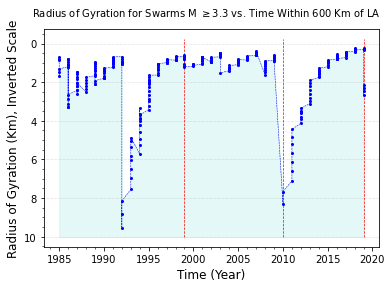


----------------------------------------------------------

Mean(Density):  930.670788264827

Log_10_mean_density_list:  2.9687960825660316

Mean Log_10(Density): -0.58 +/- 1.84

Median Log_10(Density): -1.537152775975482

Log_10_median_density_list:  -1.537152771221191

----------------------------------------------------------



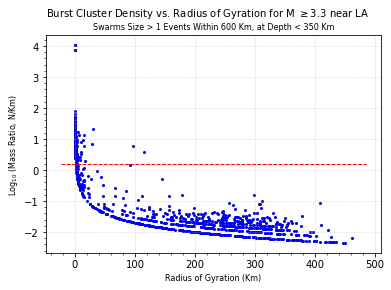


 Now working on ENF value:  -1.0
 Now working on CLF value:  5

----------------------------------------------------------

ENF, CLF, len(year_swarm), len(radgyr_EMA_list):  -1.0 5 441 441
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]

 Now working on ENF value:  -1.0
 Now working on CLF value:  10

----------------------------------------------------------

ENF, CLF, len(year_swarm), len(radgyr_EMA_list):  -1.0 10 441 441
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]

 Now working on ENF value:  -1.0
 Now working on CLF value:  15

----------------------------------------------------------

ENF, CLF, len(year_swarm), len(radgyr_EMA_list):  -1.0 15 441 441
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]

 Now working on ENF value:  -1.0
 Now working on CLF value:  20

----------------------------------------------------------

ENF, CLF, len(year_swarm), len(radgyr_EMA_list):  -1.0 20 441 441
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]

 Now working on ENF value:  -1.0
 Now working on CLF value:  25



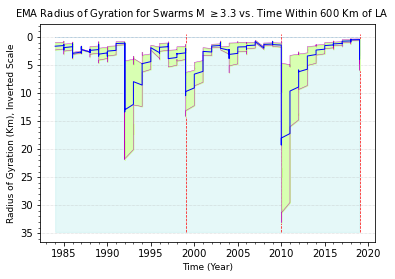

In [24]:
circle_catalog_date_start = 1984.0#1975
circle_catalog_date_end   = 2019.0
cutoff_start_year = 1984.0#1985.0
sd_factor = 25
N_Steps = 25
ratio_limit = 0.2
completeness_mag=3.3
depth = 0
completeness_mag = 3.3
Location = "LA"


burst_index, number_events, min_daily_events, burst_min_size, mag, lat, lng, date, time, years = \
                    plot_swarm_event_counts\
                            (completeness_mag , Location, sd_factor)
################

print("completed 1st")



# plot_radgyr_time(burst_min_size, completeness_mag, Location, \
#                  burst_index, mag, lat, lng, date, time, years)

######################



N_Steps, radgyr_list, year_swarm, index_swarm, centroid_lat, centroid_lng  = \
                plot_radgyr_EMA_time(burst_min_size, completeness_mag, Location,  N_Steps,\
                circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
                ratio_limit, sd_factor, cutoff_start_year)
##################
N_Steps = 25
ratio_limit = 0.2
cutoff_start_date = "1986/01/05"#"1986/11/14"
plot_cluster_density_rgyr(burst_min_size, completeness_mag, Location, N_Steps,\
                circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
                ratio_limit, cutoff_start_year)
##########################
#map_swarm_centroids(Location, burst_index, mag, lat, lng, date, time, years, cutoff_start_year, cutoff_start_date)

a,b,c,d,a2,b2,c2,d2=plot_radgyr_EMA_time_dev(burst_min_size, completeness_mag, Location, N_Steps,\
                circle_catalog_date_start, circle_catalog_date_end, burst_index, mag, lat, lng, date, time, years, \
                ratio_limit, sd_factor, cutoff_start_year)



In [25]:
a[0],b[0],c[0],d[0]

(1984, 1.633846153846154, 0.9602959905433698, 2.307396317148938)

In [26]:
len(a),len(b),len(c),len(d),len(a2),len(b2),len(c2),len(d2)

(441, 441, 441, 441, 3, 3, 3, 3)

In [27]:
a[0],b[0],c[0],d[0],a2[0],b2[0],c2[0],d2[0]

(1984,
 1.633846153846154,
 0.9602959905433698,
 2.307396317148938,
 Timestamp('1999-10-16 00:00:00'),
 '09:46:44',
 1999,
 7.1)

In [28]:
a[1],b[1],c[1],d[1],a2[1],b2[1],c2[1],d2[1]

(1985,
 1.5169230769230768,
 0.911316138956206,
 2.1225300148899477,
 Timestamp('2010-04-04 00:00:00'),
 '22:40:42',
 2010,
 7.2)

In [29]:
a[2],b[2],c[2],d[2],a2[2],b2[2],c2[2],d2[2]

(1985,
 1.3523076923076924,
 0.804512758102539,
 1.900102626512846,
 Timestamp('2019-07-06 00:00:00'),
 '03:19:53',
 2019,
 7.1)

In [30]:
start=[]
end=[]
start.append(a[0])
end.append(c2[0])
for i in range(len(c2)-1):
    start.append(c2[i])
    end.append(c2[i+1])

In [31]:
start.pop()
end.pop()

2019

In [32]:
def difference(start,end,years,mags):
    a=0
    for i in range(len(mags)):
        if years[i]==start:
            a=max(a,mags[i])
    b=a
    for i in range(len(mags)):
        if years[i]>=start and years[i]<=end:
            b=min(b,mags[i])
    return a-b

In [33]:
i=0
while i<len(start):
    if difference(start[i],end[i],a,b)==0:
        start.pop(i)
        end.pop(i)
    else:
        print(difference(start[i],end[i],a,b))
        i+=1

0.554615384615385
9.668461538461537


In [34]:
train= 0.6*len(start)
train=int(train)
test=len(start)-train
print(train,test)

1 1


In [35]:
#Calculating the train part

cutoff=0
val=[]
for i in range(train):
    val.append(difference(start[i],end[i],a,b))
#cutoff is median of the train part
val.sort()
cutoff=val[train//2]
print(cutoff)

0.554615384615385


In [38]:
#Printing stats for the train part
correct=0
for i in range(train):
    if difference(start[i],end[i],a,b)>=cutoff:
        correct+=1
print(correct,train)
print(correct/train)

1 1
1.0


In [39]:
# Printing stats for test part
correct=0
for i in range(train,len(start)):
    if difference(start[i],end[i],a,b)>=cutoff:
        correct+=1
print(correct,test)
print(correct/test)

1 1
1.0
